# Learning to Navigate with Gaussian Processes

Imagine you've landed a robot on a remote planet and are now trying to explore that planet to find potential life forms. The spaceship which landed your robot is still orbiting the planet and taking measurements of the elevation. Our goal will be to plan an energy-efficient path on the surface based on those measurements.

<p style="text-align:center;">
<img src='img/learning_to_plan_illustration.jpg' width="800">
</p>

---
ProbNum Spring School 2023
&copy; Jonathan Wenger, 2023 CC BY-NC-SA 3.0

## Setup

**Task:**  If you haven't already, install the required packages in a fresh Python environment via the following command:

```bash
cd 2023_tutorials
pip install -r requirements.txt
```

If you can execute the next cell with import statements successfully, everything should work as intended.

In [1]:
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_point_clicker import clicker
from mpl_toolkits.axes_grid1 import make_axes_locatable
#%config InlineBackend.figure_formats = ['svg']
%matplotlib widget

import tueplots
from tueplots import bundles
plt.rcParams.update(bundles.neurips2022())

cmap_norm = mpl.colors.TwoSlopeNorm(vmin=-1.25, vcenter=0.0, vmax=1.25)

# Types
from typing import Optional

# Scientific computing
import numpy as np
import scipy
import probnum
import itergp
import pykeops
pykeops.set_verbose(False)

from probnum import backend
from probnum.backend.random import RNGState
from probnum.linalg.solvers import ProbabilisticLinearSolver, information_ops, policies, LinearSolverState, beliefs
from probnum.problems import LinearSystem
from itergp.methods import belief_updates, stopping_criteria

# Tutorial-specific code
from path_planning.landscapes import generate_landscape
from path_planning.dataset import Dataset
from path_planning.cost_functions import energy_cost
from path_planning.plotting import plot_path_cost

## Simulation

Before we blast off into space, we'll start with our robot still on the ground. We'll first explore a simulated landscape to get an idea of the kind of altitude data we'll obtain based off of which we'll decide how to navigate.

**Task:** Simulate a few landscapes and corresponding datasets and get a feel for the data.

In [2]:
# Simulated landscape
seed = 999
simulated_landscape_fn = generate_landscape(seed=seed)

# Satellite measurements
num_train_data = 50000
simulated_train_data = Dataset(simulated_landscape_fn, num=num_train_data, seed=seed)

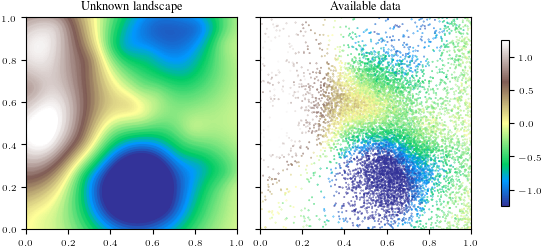

In [3]:
plt.close()

with plt.rc_context(bundles.neurips2022(rel_width=1.0)):
    fig, axs = plt.subplots(ncols=2, sharex="row", sharey="row")

    # Plot simulated landscape
    x0s = np.linspace(0, 1.0, 100)
    x1s = np.linspace(0, 1.0, 100)
    X0, X1 = np.meshgrid(x0s, x1s)
    X_test = np.vstack([X0.ravel(), X1.ravel()]).T
    F = simulated_landscape_fn(X_test).reshape(X0.shape)

    axs[0].contour(X0, X1, F, levels=50, cmap="terrain", norm=cmap_norm)
    im = axs[0].imshow(
        F, origin="lower", extent=(0.0, 1.0, 0.0, 1.0), cmap="terrain", norm=cmap_norm
    )

    # Simulated landscape data
    n_subset = np.minimum(10000, num_train_data)  # Subset training data for plot
    axs[1].scatter(
        simulated_train_data.X[0:n_subset, 0],
        simulated_train_data.X[0:n_subset, 1],
        c=simulated_train_data.y[0:n_subset],
        cmap="terrain",
        s=0.1,
        norm=cmap_norm,
    )

    # Color bar
    fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5)

    # Plot settings
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[1].set_xlim(0, 1.0)
    axs[1].set_ylim(0, 1.0)
    axs[0].set(title="Unknown landscape")
    axs[1].set(title="Available data")
    plt.show()


## Path Planning

Now to explore the remote planet we want to move our robot from a starting point to a certain location. However, we only have limited energy resources available and need to find a path that is efficient to drive along.

In [4]:
startpoint = np.asarray([0.1, 0.1])
endpoint = np.asarray([0.9, 0.9])

**Task:** Based on the simulated landscape data, plan a few paths in the widget below and measure their energy cost. Try to find a path in the simulated landscape that is energy-efficient. What factors likely determine the energy cost?

*Hint: You can plan a path by clicking on either "Path 1" or "Path 2" in the legend. Then add points by left-clicking and remove points by right-clicking near the point to be removed. The starting point is automatically part of the path.*

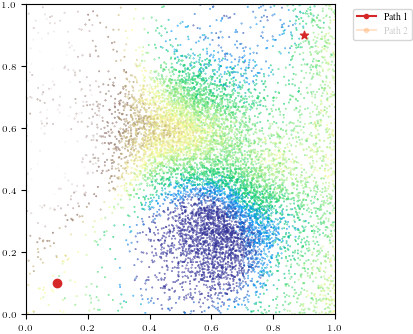

In [5]:
plt.close()

with plt.rc_context(bundles.neurips2022(rel_width=1.0)):
    fig, ax = plt.subplots()

    # Landscape data
    ax.scatter(
        simulated_train_data.X[0:n_subset, 0],
        simulated_train_data.X[0:n_subset, 1],
        c=simulated_train_data.y[0:n_subset],
        cmap="terrain",
        s=0.1,
        norm=cmap_norm,
    )

    # # Simulated landscape
    # ax.contour(X0, X1, F, levels=50, cmap="terrain", norm=cmap_norm)
    # ax.imshow(
    #     F, origin="lower", extent=(0.0, 1.0, 0.0, 1.0), cmap="terrain", norm=cmap_norm
    # )

    # Plot start and endpoints
    ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
    ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Manual path planning
    path_list = ["Path 1", "Path 2"]
    klicker = clicker(
        ax, path_list, markers=[".", "."], colors=["C3", "C1"], linestyle="-"
    )
    klicker.set_positions({path: np.reshape(startpoint, (-1, 2)) for path in path_list})

    # Plot settings
    ax.set_aspect("equal")
    # ax.set_facecolor("black")
    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 1.0)
    plt.show()


In [6]:
# Get paths from widget
path1 = np.unique(klicker.get_positions()["Path 1"], axis=0)
path2 = np.unique(klicker.get_positions()["Path 2"], axis=0)

print(path1)

[[0.1 0.1]]


In [7]:
# Measure energy cost of moving on simulated landscape
energy_cost1 = energy_cost(path1, landscape=simulated_landscape_fn)
energy_cost2 = energy_cost(path2, landscape=simulated_landscape_fn)

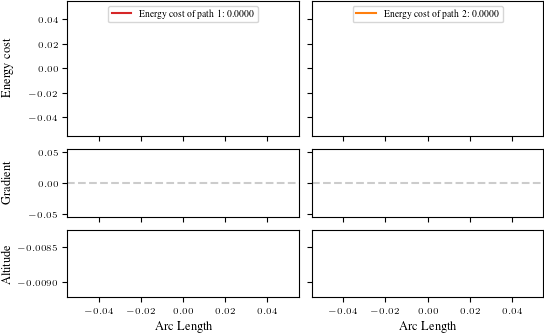

In [8]:
# Plot energy cost along path
with plt.rc_context(bundles.neurips2022(rel_width=1.0)):
    plot_path_cost(energy_cost1, energy_cost2)

In practice, we of course do *not* know the actual landscape and therefore cannot measure the energy cost of a planned path until we have actually driven to the target location. Therefore, we have *only one shot* at planning an efficient path based on the measurement data from our satellite. 

**Questions:** What potential issues make the planning problem hard if we only have measurements from our satellite available? How can we use the altitude data to still plan an efficient path?

## Learning the Landscape

We'll try to learn the surface of the remote planet from the data and then plan a path based on the inferred landscape. Since we want to use energy conservatively, we need a model which can quantify uncertainty arising from missing data to avoid unknown hills or valleys and is robust to noise in the data to avoid taking costly detours. We'll use a Gaussian process for this purpose.

### Data

Let's now use the actual data we obtain from the satellite orbiting the remote planet.

In [9]:
# True landscape unknown to our robot
landscape_fn = generate_landscape(seed=17)

# Satellite measurements
num_train_data = 50000
train_data = Dataset(landscape_fn, num=num_train_data)
train_data.X.shape

(50000, 2)

## Gaussian Processes

We will model the landscape of the remote planet using a Gaussian process
$$f \sim \mathcal{GP}(\mu, k)$$
where $\mu:\mathbb{R}^2 \to \mathbb{R}$ is the prior mean function and $k: \mathbb{R}^2 \times \mathbb{R}^2 \to \mathbb{R}$ the prior covariance function also known as a kernel.

### Prior Information

From simulation and previous missions, we have a rough idea of what geological structures on the remote planet look like and how the landscape varies. We can encode this knowledge in the prior by selecting a specific kernel. The lengthscale parameter of the kernel controls how quickly we expect the surface to change. A shorter lengthscale produces a more rapidly varying landscape than a longer lengthscale.

In [12]:
from probnum import randvars, linops
from probnum.randprocs import mean_fns
from itergp.kernels import Matern
from itergp import GaussianProcess, methods

input_shape = (2,)

# GP prior
mean_fn = mean_fns.Zero(input_shape)
kernel = Matern(input_shape, lengthscale=0.1, nu=3.5)

gp = GaussianProcess(mean_fn, kernel)

**Task:** Visualize the kernel matrix. What structure can you observe? How do you explain this structure?

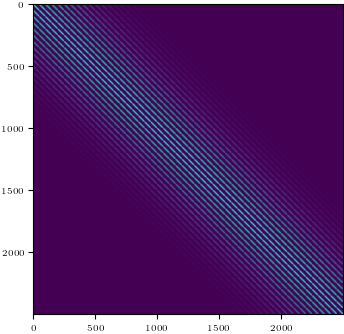

In [13]:
# Generate some test data on a 2D grid
x0s = np.linspace(0, 1.0, 50)
x1s = np.linspace(0, 1.0, 50)
X0, X1 = np.meshgrid(x0s, x1s)
X_test = np.vstack([X0.ravel(), X1.ravel()]).T

# Plot the kernel matrix
plt.close()
with plt.rc_context(bundles.neurips2022(rel_width=1.0)):
    fig, ax = plt.subplots()
    ax.imshow(kernel.matrix(X_test))
    plt.show()

**Task:** To get a feel for the assumptions encoded in our prior let's visualize it and some corresponding (slices of) draws. Vary the lengthscale parameter to see its effect on the resulting sampled landscape.

In [ ]:
# Draw samples from the Gaussian process prior
rng_state = backend.random.rng_state(0)
samples_2D = gp.sample(rng_state, X_test, sample_shape=(5,))


In [ ]:
# Prior visualization
plt.close()
with plt.rc_context(bundles.neurips2022(rel_width=1.0, ncols=2)):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)

    # 1D slice with samples
    X_test_slice = np.vstack([x0s, 0.5 * np.ones_like(x0s)]).T
    gp_mean = gp.mean(X_test_slice)
    axs[0].plot(X_test_slice, gp_mean, color="C0")
    axs[0].fill_between(
        x0s,
        y1=gp_mean + 2 * gp.std(X_test_slice),
        y2=gp_mean - 2 * gp.std(X_test_slice),
        color="C0",
        alpha=0.4,
    )

    axs[0].set(title="1D Slice of Prior")
    axs[0].plot(
        x0s,
        samples_2D.reshape(-1, *X0.shape)[:, :, 0].T,
        color="C0",
        linestyle="--",
        lw=1.0,
    )

    # Sample of prior
    axs[1].imshow(
        samples_2D.reshape(-1, *X0.shape)[0, :, :],
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm,
    )
    axs[1].set(title="Sample from Prior")

    # Plot settings
    axs[1].set_aspect("equal")
    axs[1].set_xlim(0, 1.0)
    axs[1].set_ylim(0, 1.0)

    plt.show()


### Likelihood
Let's assume we also have a rough idea of what the noise in the measurement data is that our satellite collects. The scalar $\sigma^2$ defines the expected squared deviation of a given datapoint from its true altitude.

In [14]:
# Likelihood
sigma_sq = 0.1
noise = randvars.Normal(
    mean=np.zeros_like(train_data.y),
    cov=linops.Scaling(sigma_sq, shape=(num_train_data, num_train_data)),
)

### Inference

To be able to predict the landscape of the remote planet and to ultimately plan an energy-efficient path, we need to update our prior with the information contained in the satellite measurements. The Gaussian process posterior $f \sim \mathcal{GP}(\mu_{*}, k_{*})$ is fully defined by its mean and covariance function given by

$$
\begin{align*}
    \mu_*(x) &= \mu(x) + k(x, X)\hat{K}^{-1}(y - \mu(X))\\
    k_*(x, x') &= k(x, x') - k(x, X)\hat{K}^{-1}k(X, x')
\end{align*}
$$

**Numerical Implementation**:

The textbook way to implement the mathematical operations necessary to evaluate the Gaussian process posterior is to solve the linear systems involving the symmetric positive definite kernel Gram matrix $\hat{K} = k(X, X) + \sigma^2I$ via a Cholesky factorization. This means we compute a matrix decomposition $$\operatorname{chol}(K + \sigma^2I) = LL^\top,$$ where $L$ is a lower triangular matrix and then solve $\hat{K}^{-1} b = L^{-\top}(L^{-1}b)$, where the right hand side is either $b=y - \mu(X)$ or $b=k(X, x')$. The linear solves with $L$ are efficient since $L$ is triangular.

**Task:** Implement the Gaussian process posterior using a Cholesky decomposition as [implemented in SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.cho_solve.html).

In [21]:
from scipy.linalg import cho_factor, cho_solve

# Implement Gaussian process via Cholesky decomposition

def condition_on_data(gp_prior, X_test, X_train, y_train):
    # Kernel Gram matrix
    gram_matrix = gp_prior.cov.matrix(X_train) + sigma_sq * np.eye(X_train.shape[0])

    # Cholesky factorization
    # TODO
    c, low = cho_factor(gram_matrix, lower=True)
    cho1 = cho_solve((c, low), (y_train-gp_prior.mean(X_train)))
    

    # Kernel evaluated at training data
    KXx = gp_prior.cov.matrix(X_train, X_test)
    cho2 = cho_solve((c, low), KXx)


    # Posterior mean
    post_mean = gp_prior.mean(X_test) + KXx.T @ cho1# TODO

    # Posterior covariance
    post_cov = (
        gp_prior.cov.matrix(X_test)
        - KXx.T @ cho2
    )

    return post_mean, post_cov


**Task:** Test your implementation on a small training and test dataset.

In [25]:
# Training data
X_train = train_data.X[0:500]
y_train = train_data.y[0:500]

# Test data
x0s = np.linspace(0, 1.0, 50)
x1s = np.linspace(0, 1.0, 50)
X0, X1 = np.meshgrid(x0s, x1s)
X_test = np.vstack([X0.ravel(), X1.ravel()]).T

# Compute GP posterior
post_mean, post_cov = condition_on_data(gp, X_test, X_train, y_train)

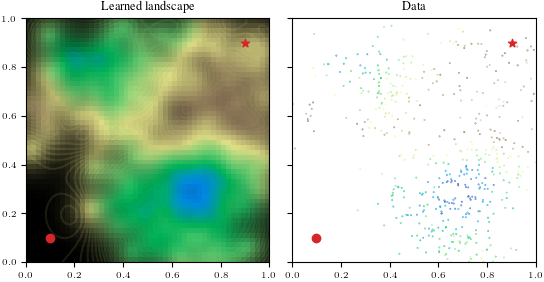

In [26]:
plt.close()

with plt.rc_context(bundles.neurips2022(rel_width=1.0)):
    fig, axs = plt.subplots(ncols=2, sharex="row", sharey="row")

    # Plot inferred landscape
    use_uncertainty_overlay = True

    if use_uncertainty_overlay:
        uncertainty = np.sqrt(np.diag(post_cov))
        black_background = np.full((*X0.shape, 3), 0, dtype=np.uint8)
        uncertainty_overlay = np.clip(1.0 - uncertainty.reshape(X0.shape), 0.0, 1.0)
        axs[0].imshow(black_background)

    axs[0].contour(
        X0,
        X1,
        post_mean.reshape(X0.shape),
        levels=50,
        cmap="terrain",
        alpha=0.1,
        norm=cmap_norm,
    )
    axs[0].imshow(
        post_mean.reshape(X0.shape),
        alpha=uncertainty_overlay if use_uncertainty_overlay else None,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm,
    )

    # Plot start and endpoints
    for ax in axs:
        ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
        ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Data
    axs[1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="terrain", s=0.1)

    # Plot settings
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[1].set_xlim(0, 1.0)
    axs[1].set_ylim(0, 1.0)
    axs[0].set(title="Learned landscape")
    axs[1].set(title="Data")
    plt.show()


## Scaling to Large Datasets

Using only a hundred datapoints of the dataset we have available potentially discards important information. We have a lot more data available. Can we use more of the training data to plan a better path?

**Task:** Try to condition your implementation of a GP on 50k datapoints. What happens and why?

In [24]:
# Large training dataset
X_train = train_data.X
y_train = train_data.y

post_mean, post_var = condition_on_data(gp, X_test, X_train, y_train)


MemoryError: Unable to allocate 37.3 GiB for an array with shape (50000, 50000, 2) and data type float64

Trying to form the kernel matrix $K=k(X, X) \in \mathbb{R}^{n \times n}$ in memory to perform the Cholesky decomposition with 50k datapoints quickly becomes prohibitive both in terms of time and space. Does that mean we cannot use Gaussian processes in the large-scale setting? Not at all as we will see next!

## Computation-aware Gaussian Processes

To scale our Gaussian process to larger datasets we could try to approximate it using any number of techniques. However, as we've seen in Prof. Cunningham's talk, this can introduce lots of hidden pathologies in the uncertainty quantification. But this is the main reason, we use a GP in the first place! We want to know which regions to avoid since they may be way to costly to drive through and we might get stuck. 

Instead, what we need is a way to compute a belief over the landscape with whatever limited resources we have available on our satellite and robot, *without* sacrificing uncertainty quantification. As we will see, we can accept more uncertainty to obtain a faster prediction of the landscape. 

As a first step, we will tackle the memory issue for large-scale problems.

### Matrix-free Kernel Matrices

While kernel matrices are generally dense and therefore need $\mathcal{O}(n^2)$ memory, they are highly structured as we saw earlier. This structure is generally not sparsity, which directly allows memory-efficient storage, but a symbolic representation.

<p style="text-align:center;">
<img src='img/keops.png' width="800">
</p>

**Question:** Can you think of a way we could exploit this structure induced by our probabilistic model for efficient computation? Is there a way to multiply with the kernel matrix without having to use $\mathcal{O}(n^2)$ memory?

**Answer:** ...

**Task:** Create a kernel "linear operator" via `kernel.linop` instead of `kernel.matrix` which gives a matrix-free representation of the kernel matrix and multiply with a vector with 50k entries. How long does formation of the matrix-free representation take and how long does the matrix-vector product take on your machine?

*Hint: The syntax of matrix multiplication is the same for linear operators as for numpy arrays.*

In [28]:
# Matrix-free representation of kernel matrix as "linear operator"
K = kernel.linop(train_data.X)

In [32]:
# Large-scale matrix-vector product
(K @ np.ones(num_train_data)).shape

(50000,)

### Iterative Computation-aware Inference

We can make use of a much larger number of measurements to infer the landscape of the remote planet, if we approximate the Gaussian process posterior using matrix-vector multiplication. Recall the form of the Gaussian process posterior $f \sim \mathcal{GP}(\mu_{*}, k_{*})$ from above:

$$
\begin{align*}
    \mu_*(x) &= \mu(x) + k(x, X)\hat{K}^{-1}(y - \mu(X))\\
    k_*(x, x') &= k(x, x') - k(x, X)\hat{K}^{-1}k(X, x')
\end{align*}
$$

Instead of using a Cholesky decomposition, which requires the dense kernel matrix in memory, we can use an *iterative* probabilistic linear solver to approximate the representer weights $v_* = \hat{K}^{-1}(y - \mu(X))$ and the precision matrix $\hat{K}^{-1}$. In each iteration the solver performs a matrix vector multiplication $v \mapsto \hat{K}v$ with the kernel matrix as its main operation, meaning we can use the matrix-free representation from above and never actually have to form $\hat{K} \in \mathbb{R}^{n \times n}$ in memory. 

After $i$ iterations the solver returns a combined GP posterior given by

$$
\begin{align*}
    \mu_i(x) &= \mu(x) + k(x, X)v_i\\
    k_i(x, x') &= k(x, x') - k(x, X)C_ik(X, x')
\end{align*}
$$
where $v_i = C_i (y - \mu(X)) \approx v_* = \hat{K}^{-1}(y - \mu(X))$ and $C_i \approx \hat{K}^{-1}$ is a rank $i$ matrix. Notice the similarities to the mathematical GP posterior above.

Now the reason for using a *probabilistic* linear solver is that it quantifies the approximation error from running only a few iterations due to our limited budget. If we perform $i<n$ iterations, the combined posterior is always more uncertain than the mathematical posterior, since we have not invested enough computation yet. This allows us to trade off faster computation for increased uncertainty, in the same way using less data does.

**Task:** Compute an (approximate) GP posterior which quantifies uncertainty from limited data *and* limited computation via one instance of a probabilistic linear solver below.

In [33]:
# One variant of a probabilistic linear solver
pls = methods.Cholesky(maxrank=100)

# Iteratively computed combined GP posterior
gp_post = gp.condition_on_data(
    train_data.X, train_data.y, noise, approx_method=pls
)


One immediately noticable benefit of making this tradeoff is that we can operate on the entire dataset to compute an (approximate) posterior. We can also predict on a much larger number of datapoints.

**Task:** Predict the landscape at a million test datapoints using the GP posterior above.

In [34]:
# Marginal GP prediction on a million datapoints
x0s = np.linspace(0, 1.0, 1000)
x1s = np.linspace(0, 1.0, 1000)
X0, X1 = np.meshgrid(x0s, x1s)
X_test = np.vstack([X0.ravel(), X1.ravel()]).T
y_test = gp_post.mean(X_test)
uncertainty = gp_post.std(X_test)


In [35]:
X_test.shape

(1000000, 2)

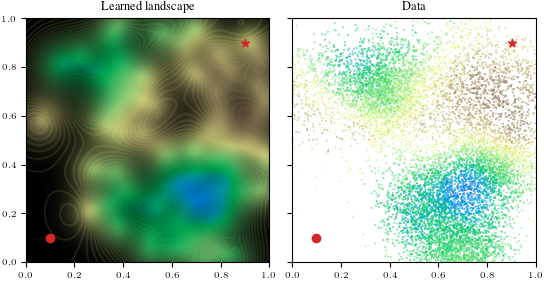

In [36]:
plt.close()

with plt.rc_context(bundles.neurips2022(rel_width=1.0)):
    fig, axs = plt.subplots(ncols=2, sharex="row", sharey="row")

    # Plot inferred landscape
    use_uncertainty_overlay = True

    if use_uncertainty_overlay:
        black_background = np.full((*X0.shape, 3), 0, dtype=np.uint8)
        uncertainty_overlay = np.clip(1.0 - uncertainty.reshape(X0.shape), 0.0, 1.0)
        axs[0].imshow(black_background)

    axs[0].contour(
        X0,
        X1,
        y_test.reshape(X0.shape),
        levels=50,
        cmap="terrain",
        alpha=0.1,
        norm=cmap_norm,
    )
    axs[0].imshow(
        y_test.reshape(X0.shape),
        alpha=uncertainty_overlay if use_uncertainty_overlay else None,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm,
    )

    # Plot start and endpoints
    for ax in axs:
        ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
        ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Data
    n_subset = np.minimum(10000, num_train_data)  # Subset training data for plot
    axs[1].scatter(
        train_data.X[0:n_subset, 0],
        train_data.X[0:n_subset, 1],
        c=train_data.y[0:n_subset],
        cmap="terrain",
        s=0.1,
        norm=cmap_norm,
    )

    # Plot settings
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[1].set_xlim(0, 1.0)
    axs[1].set_ylim(0, 1.0)
    axs[0].set(title="Learned landscape")
    axs[1].set(title="Data")
    plt.show()


### Designing Your Own Policy

In each iteration the probabilistic linear solver chooses an *action* $s_i \in \mathbb{R}^n$ where the absolute value of each entry roughly describes how much a datapoint should enter into our prediction. The more we target a datapoint, the more certain we become in that region of the input space. This allows us to trade off expensive precision for faster inference with additional uncertainty in regions of the input space where we do not need to know precisely what the landscape is for planning. Next, you will design your own probabilistic linear solver for this specific problem by designing a policy, i.e. a function which for each call returns a new vector $s_i$, that describes where to target computation next.

As an example, the simplest policy chooses unit vectors $s_i = (0, \dots, 0, 1, 0, \dots, 0)^\top \in \mathbb{R}^n$ in each iteration with a $1$ in the $i$ th entry, signifying we target only the $i$ th datapoint in that iteration. This turns out to be equivalent to sequentially conditioning a GP on the first $i$ datapoints of the dataset.

In [39]:
class UnitVectorPolicy(policies.LinearSolverPolicy):
    def __call__(
        self,
        solver_state: "probnum.linalg.solvers.LinearSolverState",
        rng: Optional[RNGState] = None,
    ) -> backend.Array:
        # Size of kernel matrix
        n = solver_state.problem.A.shape[1] 
        
        # Action full of zeros
        action = np.zeros(n)

        # Set ith entry to 1.0
        action[solver_state.step] = 1.0

        return action

**Task:** Generate a few actions by instantiating a `UnitVectorPolicy` and calling the resulting object multiple times.

In [41]:
# Linear system to be solved
Khat = kernel.linop(train_data.X) + sigma_sq * linops.Identity(num_train_data)
linear_system = LinearSystem(Khat, train_data.y)

# Initialize the state of the probabilistic linear solver
linear_system_belief = beliefs.LinearSystemBelief(Ainv=linops.Zero(shape=(num_train_data, num_train_data)), b=train_data.y)
solver_state = LinearSolverState(linear_system, linear_system_belief)

# Define a unit vector policy
# TODO
mypolicy = UnitVectorPolicy()

# Generated actions
for i in range(5):
    # TODO: Print result of calling the policy in each step
    print(mypolicy(solver_state))
    # Advance the solver to the next step
    solver_state.next_step()

[1. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]




Another option is to weigh your datapoints according to how large the difference between your model's prediction is and the observed datapoint $y_i$. This corresponds to choosing the current residual $s_i = (y_i - \mu(x_i)) - \hat{K}v_i  = y_i - (\mu(x_i) + \hat{K}v_i)$ as an action in each iteration. The approximate representer weights in this case are equal to the ones computed by the method of conjugate gradients, a popular linear solver for positive definite linear systems. This is also how libraries like [GPyTorch](https://gpytorch.ai/) work internally.

In [42]:
class ResidualPolicy(policies.LinearSolverPolicy):
    def __call__(
        self,
        solver_state: "probnum.linalg.solvers.LinearSolverState",
        rng: Optional[RNGState] = None,
    ) -> backend.Array:
        return solver_state.residual 

In [43]:
ResidualPolicy()(solver_state)

array([-0.50384647, -0.8628427 , -0.21751727, ..., -0.41688968,
       -0.17926131, -0.52268188])

**Task**: Try a few policies and compute the corresponding combined posteriors below. Be mindful that actions with few zeros are more costly per iteration than very sparse actions.

In [83]:
class RandomUnitVectorPolicy(policies.LinearSolverPolicy):
    def __call__(
        self,
        solver_state: "probnum.linalg.solvers.LinearSolverState",
        rng: Optional[RNGState] = None,
    ) -> backend.Array:
        
        # Action full of zeros
        action = np.zeros(solver_state.problem.A.shape[1])
        
        if solver_state.step == 0:
            # Random number generator from state.
            rng = np.random.default_rng(rng)

            # Random permutation of available data indices
            shuffled_indices = rng.permutation(solver_state.problem.A.shape[1])

            # Store shuffled indices between calls of policy
            solver_state.cache["shuffled_indices"] = shuffled_indices

        nonzero_idx = solver_state.cache["shuffled_indices"][solver_state.step]
        action[nonzero_idx] = 1.0

        return action

class RandomGaussianPolicy(policies.LinearSolverPolicy):
    def __call__(
        self,
        solver_state: "probnum.linalg.solvers.LinearSolverState",
        rng: Optional[RNGState] = None,
    ) -> backend.Array:
        # Random number generator from state.
        rng = np.random.default_rng(rng)

        # Random Gaussian actions
        return rng.standard_normal(size=(solver_state.problem.A.shape[1],))
    
class SelectionPolicy(policies.LinearSolverPolicy):
    def __call__(
        self,
        solver_state: "probnum.linalg.solvers.LinearSolverState",
        rng: Optional[RNGState] = None,
    ) -> backend.Array:
        action = np.zeros(solver_state.problem.A.shape[1])

        # Select data on diagonal of domain
        idcs = np.where(np.abs(train_data.X[:, 0] - train_data.X[:, 1]) < 0.2)[0]

        # Use residual (gradient) actions
        action[idcs[solver_state.step]] = 1.0

        return action
    
class LevelSetPolicy(policies.LinearSolverPolicy):
    def __call__(
        self,
        solver_state: "probnum.linalg.solvers.LinearSolverState",
        rng: Optional[RNGState] = None,
    ) -> backend.Array:
        action = np.zeros(solver_state.problem.A.shape[1])

        # Target data with altitude similar to starting altitude to find level set
        idcs = np.where(np.abs(train_data.y - landscape_fn(startpoint)) < 0.05)[0]

        # Use residual (gradient) actions
        action[idcs] = solver_state.residual[idcs]

        return action
    
class SubsetResidualPolicy(policies.LinearSolverPolicy):
    def __call__(
        self,
        solver_state: "probnum.linalg.solvers.LinearSolverState",
        rng: Optional[RNGState] = None,
    ) -> backend.Array:
        # CG on subset of data
        action = np.zeros(solver_state.problem.A.shape[1])
        action[0:2000] = solver_state.residual[0:2000]

        return action

In [114]:
# Define a probabilistic linear solver from a given policy

    def __call__(
        self,
        solver_state: "probnum.linalg.solvers.LinearSolverState",
        rng: Optional[RNGState] = None,
    ) -> backend.Array:
        """Return an action for a given solver state.

        Parameters
        ----------
        solver_state
            Current state of the linear solver.
        rng
            Random number generator state.

        Returns
        -------
        action
            Next action to take. Must have shape=(n,).
        """
        # TODO: come up with your own policy!
        action = np.zeros(solver_state.problem.A.shape[1])

        # Target data with altitude similar to starting altitude to find level set
        idcs = np.where(np.abs(train_data.y - landscape_fn(startpoint)) < 0.05)[0]

        # Use residual (gradient) actions
        action[idcs] = solver_state.residual[idcs]
        
        rng = np.random.default_rng(rng)
        rand_idc = rng.integers(0,len(action),200)
        
        diag_idcs = np.where(np.abs(train_data.X[:, 0] - train_data.X[:, 1]) < 0.1)[0]
        
        #print(rand_idc)
        action[rand_idc] = 1
        action[rng.choice(diag_idcs,200)] = 1

        return action

In [115]:
class MySolver(ProbabilisticLinearSolver):
    def __init__(
        self,
        atol: float = 1e-5,
        rtol: float = 1e-5,
        maxiter: int = None,
    ):
        super().__init__(
            policy=RandomUnitVectorPolicy(), # TODO: Swap out the policy here
            information_op=information_ops.ProjectedResidualInformationOp(),
            belief_update=belief_updates.ProjectedResidualBeliefUpdate(),
            stopping_criterion=stopping_criteria.MaxIterationsStoppingCriterion(
                maxiter=maxiter,
            )
            | probnum.linalg.solvers.stopping_criteria.ResidualNormStoppingCriterion(
                atol=atol, rtol=rtol
            ),
        )


In [117]:
# Compute combined posterior (uncertainty from limited data + uncertainty from limited computation)
gp_post = gp.condition_on_data(
    train_data.X, train_data.y, noise, approx_method=MySolver(maxiter=5) 
    # You can adjust your compute budget by adjusting the number of iterations
)

In [118]:
# Marginal GP prediction
x0s = np.linspace(0, 1.0, 100)
x1s = np.linspace(0, 1.0, 100)
X0, X1 = np.meshgrid(x0s, x1s)
X_test = np.vstack([X0.ravel(), X1.ravel()]).T
y_test = gp_post.mean(X_test)
uncertainty = gp_post.std(X_test)

**Task:** Plan a path based on the computation-aware GP prediction. Experiment with different policies and try to find one which let's you efficiently plan a path.

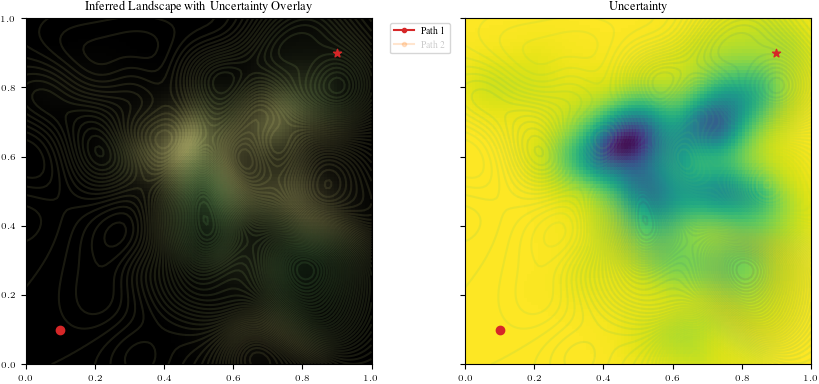

In [119]:
plt.close()

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.5)):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)

    # Use uncertainty overlay
    use_uncertainty_overlay = True

    # Evaluate landscape function for plotting
    if use_uncertainty_overlay:
        black_background = np.full((*X0.shape, 3), 0, dtype=np.uint8)
        axs[0].imshow(black_background)
        uncertainty_overlay = np.clip(1.0 - uncertainty.reshape(X0.shape), 0.0, 1.0)

    axs[0].contour(
        X0,
        X1,
        y_test.reshape(X0.shape),
        levels=50,
        cmap="terrain",
        alpha=0.1,
        norm=cmap_norm,
    )
    axs[0].imshow(
        y_test.reshape(X0.shape),
        alpha=uncertainty_overlay if use_uncertainty_overlay else None,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm,
    )

    # Uncertainty
    axs[1].contour(X0, X1, y_test.reshape(X0.shape), levels=50, alpha=0.1)
    axs[1].imshow(
        uncertainty.reshape(X0.shape),
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
    )

    # Plot start and endpoints
    for ax in axs:
        ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
        ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Manual path planning
    path_list = ["Path 1", "Path 2"]
    klicker = clicker(
        axs[0], path_list, markers=[".", "."], colors=["C3", "C1"], linestyle="-"
    )
    klicker.set_positions({path: np.reshape(startpoint, (-1, 2)) for path in path_list})

    # Plot settings
    axs[0].set_title(
        "Inferred Landscape with Uncertainty Overlay"
        if use_uncertainty_overlay
        else "Inferred Landscape"
    )
    axs[1].set_title("Uncertainty")
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[0].set_xlim(0, 1.0)
    axs[0].set_ylim(0, 1.0)
    plt.show()


**Task:** Predict the energy cost of your planned paths using the computation-aware Gaussian process.

In [120]:
# Get paths from widget
path1 = np.unique(klicker.get_positions()["Path 1"], axis=0)
path2 = np.unique(klicker.get_positions()["Path 2"], axis=0)

# Predict energy cost of based on GP
energy_cost1 = energy_cost(path1, landscape=gp_post.mean)
energy_cost2 = energy_cost(path2, landscape=gp_post.mean)

with plt.rc_context(bundles.neurips2022(usetex=True, rel_width=1.0)):
    plot_path_cost(energy_cost1, energy_cost2)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

**Task**: Now it's time to come up with your own policy. Think about what datapoints are helpful to target and where you can save compute. How you target the datapoints (i.e. what values the entries of the action have) is also important. Be mindful that actions with few zeros are more costly per iteration than very sparse actions.

In [ ]:
class MyPolicy(policies.LinearSolverPolicy):
    def __init__(self) -> None:
        super().__init__()

    def __call__(
        self,
        solver_state: "probnum.linalg.solvers.LinearSolverState",
        rng: Optional[RNGState] = None,
    ) -> backend.Array:
        """Return an action for a given solver state.

        Parameters
        ----------
        solver_state
            Current state of the linear solver.
        rng**Task:** Try to refine your policy above to obtain a more useful prediction for path planning. Think about where you can save computation by accepting more (computational) uncertainty. Can you plan a path that is predicted to be more efficient? How much can you trust that prediction?

            Random number generator state.

        Returns
        -------
        action
            Next action to take. Must have shape=(n,).
        """
        # TODO: come up with your own policy!

**Task:** Try to refine your policy above to obtain a more useful prediction for path planning. Think about where you can save computation by accepting more (computational) uncertainty. Can you plan a path that is predicted to be more efficient? How much can you trust that prediction?


---

**ATTENTION: Do not continue below until prompted by the tutorial organizers.** You don't want to spoil the fun, do you? :)

---

## True Energy Cost

Let's see how good the path is you've chosen based on the learned landscape!

**Task:** Drive your robot along the defined paths above and measure the true energy cost.

In [ ]:
plt.close()

with plt.rc_context(bundles.neurips2022(rel_width=1.0)):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True)

    # Inferred landscape with uncertainty overlay
    axs[0].imshow(black_background)
    axs[0].contour(
        X0,
        X1,
        y_test.reshape(X0.shape),
        levels=50,
        cmap="terrain",
        alpha=0.1,
        norm=cmap_norm,
    )
    axs[0].imshow(
        y_test.reshape(X0.shape),
        alpha=uncertainty_overlay if use_uncertainty_overlay else None,
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm,
    )

    # Actual landscape
    y_true = landscape_fn(X_test)
    axs[1].contour(
        X0, X1, y_true.reshape(X0.shape), levels=50, alpha=0.1, norm=cmap_norm
    )
    axs[1].imshow(
        y_true.reshape(X0.shape),
        origin="lower",
        extent=(0.0, 1.0, 0.0, 1.0),
        cmap="terrain",
        norm=cmap_norm,
    )

    # Plot start and endpoints
    for ax in axs[0:2]:
        ax.scatter(startpoint[0], startpoint[1], marker="o", color="C3", zorder=10)
        ax.scatter(endpoint[0], endpoint[1], marker="*", color="C3", zorder=10)

    # Plot paths
    for ax in axs[0:2]:
        ax.plot(
            path1[:, 0], path1[:, 1], "-o", markersize=2, color="C3", label="Path 1"
        )
        ax.plot(
            path2[:, 0], path2[:, 1], "-o", markersize=2, color="C1", label="Path 2"
        )

    # Plot settings
    axs[0].set_title(
        "Inferred Landscape with Uncertainty Overlay"
        if use_uncertainty_overlay
        else "Inferred Landscape"
    )
    axs[1].set_title("True Landscape")
    axs[0].set_aspect("equal")
    axs[1].set_aspect("equal")
    axs[0].set_xlim(0, 1.0)
    axs[0].set_ylim(0, 1.0)

    # Legend
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(
        handles=handles,
        labels=labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.05),
        fancybox=False,
        shadow=False,
        ncol=2,
        frameon=False,
    )

    plt.show()


**Task:** Compare with the people sitting next to you who found the path with the least energy cost! No cheating and changing the path after having seen the true landscape allowed ;)


In [ ]:
# Measure energy cost of moving on actual landscape
energy_cost1 = energy_cost(path1, landscape=landscape_fn)
energy_cost2 = energy_cost(path2, landscape=landscape_fn)

with plt.rc_context(bundles.neurips2022(rel_width=1.0)):
    plot_path_cost(energy_cost1, energy_cost2)

## Conclusion

### Takeaways
- GPs scale to large datasets!
- GPs allow us to trade off accuracy for uncertainty, exactly and explicitly.
- Limited data *and* limited computation induce uncertainty.

### Extensions?

How could we improve the path planning even further? Let's hear your suggestions!

## References

### Software Libraries
If you've enjoyed this tutorial, you can support the developers of the underlying libraries, including us, by starring the underlying libraries on GitHub:

- [ProbNum](https://github.com/probabilistic-numerics/probnum): Probabilistic Numerics in Python.
- [IterGP](https://github.com/JonathanWenger/itergp): Computation-aware Gaussian Processes.
- [KeOps](https://github.com/getkeops/keops): Kernel Operations on the GPU, with autodiff, without memory overflows.
- [GPyTorch](https://github.com/cornellius-gp/gpytorch): Gaussian processes with GPU acceleration.

### Research
If you want to read more about the research this tutorial is based on, check out the following paper:

> J. Wenger, G. Pleiss, M. Pförtner, P. Hennig, and J. P. Cunningham. “Posterior and
Computational Uncertainty in Gaussian Processes”. In: *Advances in Neural Information
Processing Systems (NeurIPS)*. 2022. [arXiv: 2205.15449](https://arxiv.org/abs/2205.15449)